In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Prefer the processed dataset (output of Task 1). If not present, load Excel directly.
PROCESSED_PATH = '../data/processed/ethiopia_fi_unified_data_enriched.csv'
DATA_XLSX_PATH = '../data/raw/ethiopia_fi_unified_data.xlsx'

try:
    df = pd.read_csv(PROCESSED_PATH)
    source_used = PROCESSED_PATH
except FileNotFoundError:
    df_main = pd.read_excel(DATA_XLSX_PATH, sheet_name='ethiopia_fi_unified_data')
    try:
        df_impact = pd.read_excel(DATA_XLSX_PATH, sheet_name='Impact_sheet')
    except ValueError:
        df_impact = pd.DataFrame()

    all_cols = sorted(set(df_main.columns).union(set(df_impact.columns)))
    df_main = df_main.reindex(columns=all_cols)
    df_impact = df_impact.reindex(columns=all_cols)
    df = pd.concat([df_main, df_impact], ignore_index=True)
    source_used = DATA_XLSX_PATH + " (combined sheets)"

print(f"Loaded {len(df)} records from: {source_used}")

Loaded 57 records from: ../data/raw/ethiopia_fi_unified_data.xlsx (combined sheets)


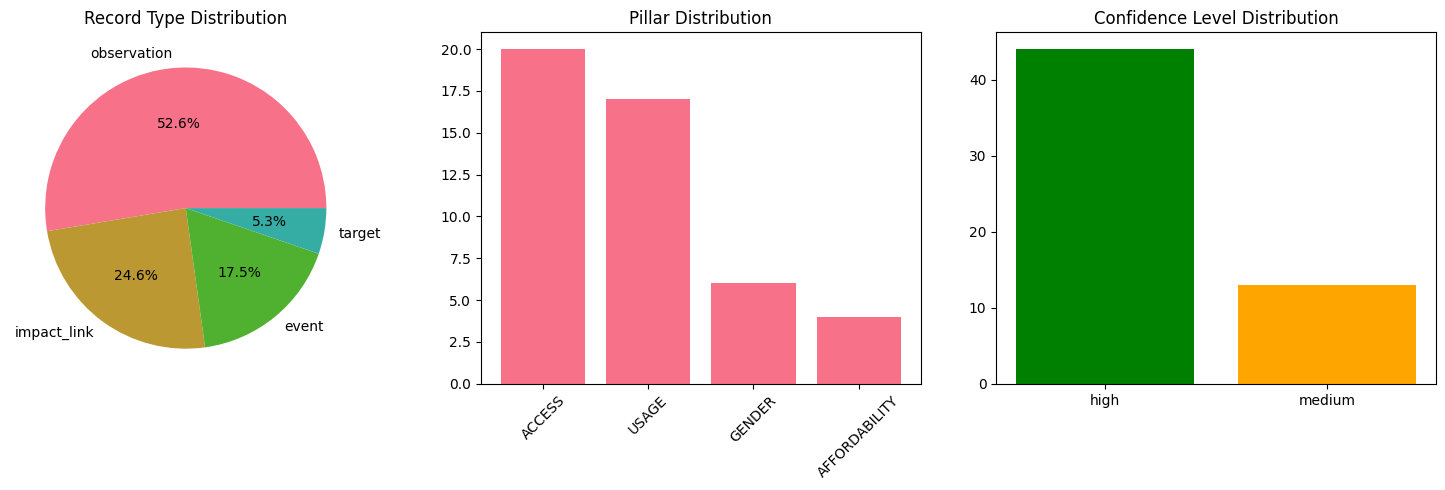

Dataset Summary:
Total records: 57
Observations: 30
Events: 10
Impact Links: 14
Targets: 3


In [3]:
# Record type distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Record types
record_counts = df['record_type'].value_counts()
axes[0].pie(record_counts.values, labels=record_counts.index, autopct='%1.1f%%')
axes[0].set_title('Record Type Distribution')

# Pillar distribution (for records that have pillars)
pillar_data = df[df['pillar'].notna()]
pillar_counts = pillar_data['pillar'].value_counts()
axes[1].bar(pillar_counts.index, pillar_counts.values)
axes[1].set_title('Pillar Distribution')
axes[1].tick_params(axis='x', rotation=45)

# Confidence distribution
conf_counts = df['confidence'].value_counts()
axes[2].bar(conf_counts.index, conf_counts.values, color=['green', 'orange', 'red'])
axes[2].set_title('Confidence Level Distribution')

plt.tight_layout()
plt.show()

print("Dataset Summary:")
print(f"Total records: {len(df)}")
print(f"Observations: {len(df[df['record_type'] == 'observation'])}")
print(f"Events: {len(df[df['record_type'] == 'event'])}")
print(f"Impact Links: {len(df[df['record_type'] == 'impact_link'])}")
print(f"Targets: {len(df[df['record_type'] == 'target'])}")

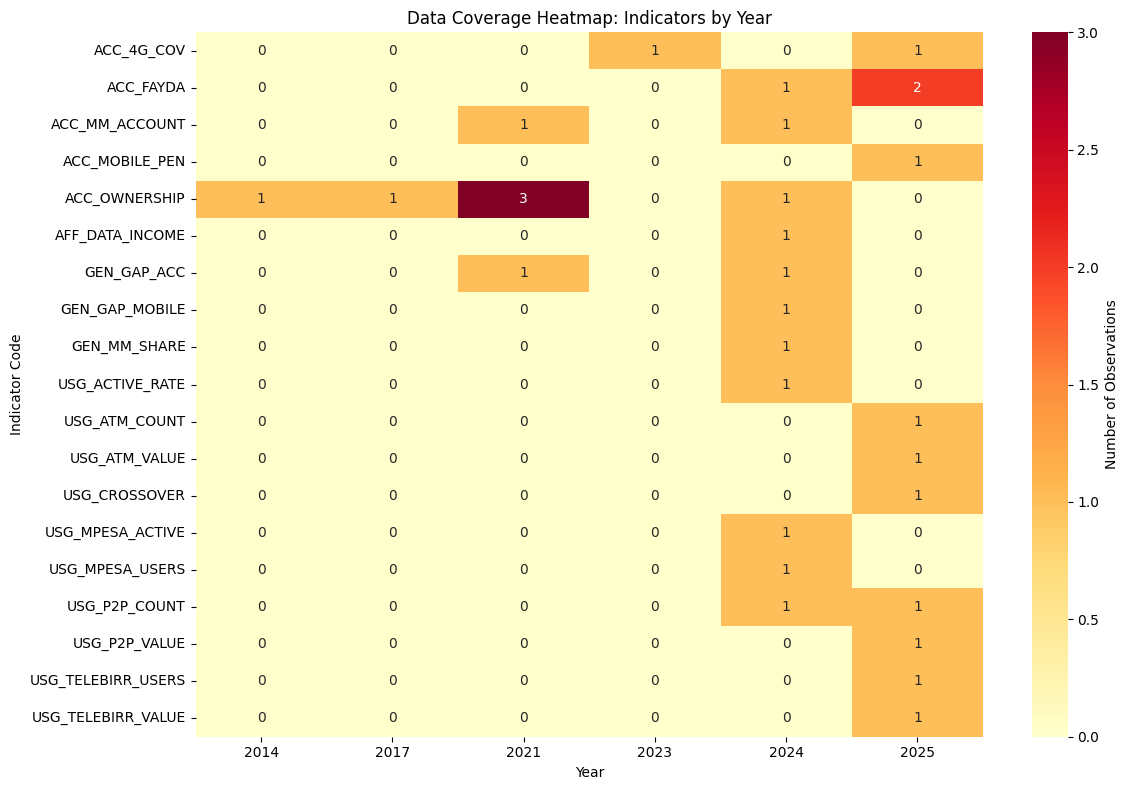

Coverage Summary:
Date range: 2014-12-31 00:00:00 to 2025-12-31 00:00:00
Years covered: [np.int32(2014), np.int32(2017), np.int32(2021), np.int32(2023), np.int32(2024), np.int32(2025)]
Indicators with data: 19


In [4]:
# Prepare temporal data
observations = df[df['record_type'] == 'observation'].copy()

# Excel exports often contain mixed datetime formats (date-only + full timestamp)
observations['observation_date'] = pd.to_datetime(
    observations['observation_date'],
    format='mixed',
    errors='coerce',
)

# Drop rows where date couldn't be parsed (keeps downstream plots stable)
observations = observations.dropna(subset=['observation_date'])
observations['year'] = observations['observation_date'].dt.year

# Coverage heatmap
coverage_matrix = observations.pivot_table(
    index='indicator_code',
    columns='year',
    values='value_numeric',
    aggfunc='count',
    fill_value=0,
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    coverage_matrix,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    cbar_kws={'label': 'Number of Observations'},
)
plt.title('Data Coverage Heatmap: Indicators by Year')
plt.xlabel('Year')
plt.ylabel('Indicator Code')
plt.tight_layout()
plt.show()

print('Coverage Summary:')
print(f"Date range: {observations['observation_date'].min()} to {observations['observation_date'].max()}")
print(f"Years covered: {sorted(observations['year'].unique())}")
print(f"Indicators with data: {observations['indicator_code'].nunique()}")


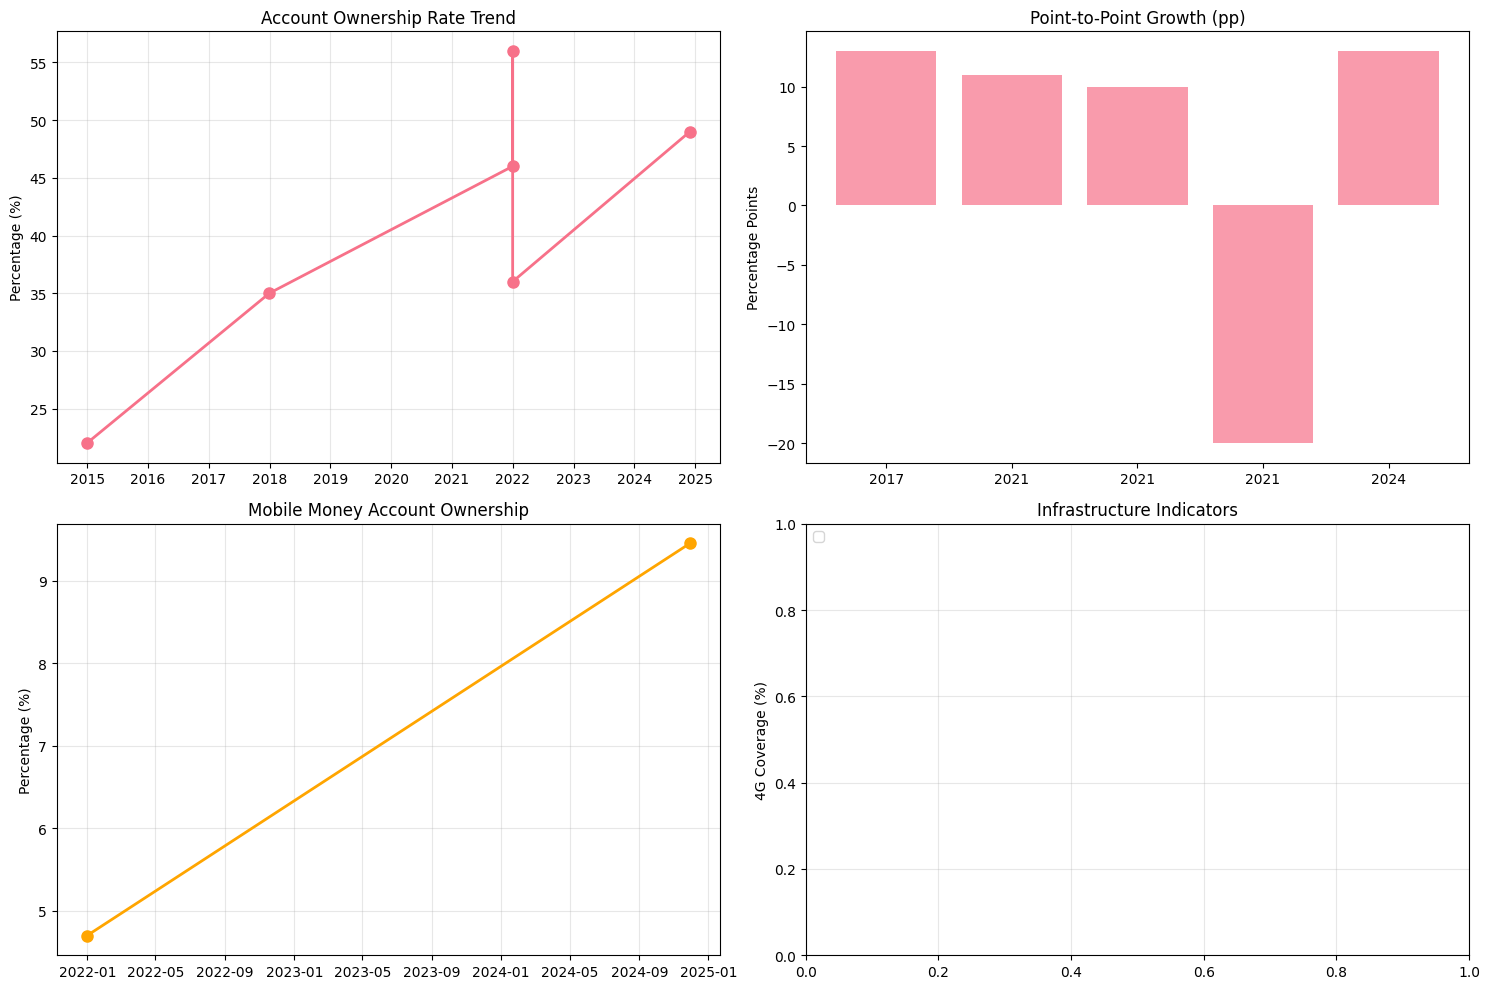

In [5]:
# Access indicators analysis
access_obs = observations[observations['pillar'] == 'ACCESS'].copy()

# Account ownership trend
acc_ownership = access_obs[access_obs['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')
mm_accounts = access_obs[access_obs['indicator_code'] == 'ACC_MM_ACCOUNT'].sort_values('observation_date')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Account ownership trend
if not acc_ownership.empty:
    axes[0,0].plot(acc_ownership['observation_date'], acc_ownership['value_numeric'], 'o-', linewidth=2, markersize=8)
    axes[0,0].set_title('Account Ownership Rate Trend')
    axes[0,0].set_ylabel('Percentage (%)')
    axes[0,0].grid(True, alpha=0.3)
    
    # Calculate growth rates
    if len(acc_ownership) > 1:
        growth_rates = acc_ownership['value_numeric'].diff()
        axes[0,1].bar(range(1, len(growth_rates)), growth_rates[1:], alpha=0.7)
        axes[0,1].set_title('Point-to-Point Growth (pp)')
        axes[0,1].set_ylabel('Percentage Points')
        axes[0,1].set_xticks(range(1, len(growth_rates)))
        axes[0,1].set_xticklabels([f"{int(y)}" for y in acc_ownership['year'].iloc[1:]])

# Mobile money accounts
if not mm_accounts.empty:
    axes[1,0].plot(mm_accounts['observation_date'], mm_accounts['value_numeric'], 'o-', color='orange', linewidth=2, markersize=8)
    axes[1,0].set_title('Mobile Money Account Ownership')
    axes[1,0].set_ylabel('Percentage (%)')
    axes[1,0].grid(True, alpha=0.3)

# Infrastructure indicators
infra_indicators = ['INF_4G_COVERAGE', 'INF_MOBILE_PENETRATION']
for i, indicator in enumerate(infra_indicators):
    infra_data = access_obs[access_obs['indicator_code'] == indicator].sort_values('observation_date')
    if not infra_data.empty:
        if i == 0:
            axes[1,1].plot(infra_data['observation_date'], infra_data['value_numeric'], 'o-', label=indicator, linewidth=2, markersize=6)
        else:
            ax2 = axes[1,1].twinx()
            ax2.plot(infra_data['observation_date'], infra_data['value_numeric'], 'o-', color='red', label=indicator, linewidth=2, markersize=6)
            ax2.set_ylabel('Mobile Penetration (%)', color='red')

axes[1,1].set_title('Infrastructure Indicators')
axes[1,1].set_ylabel('4G Coverage (%)')
axes[1,1].legend(loc='upper left')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

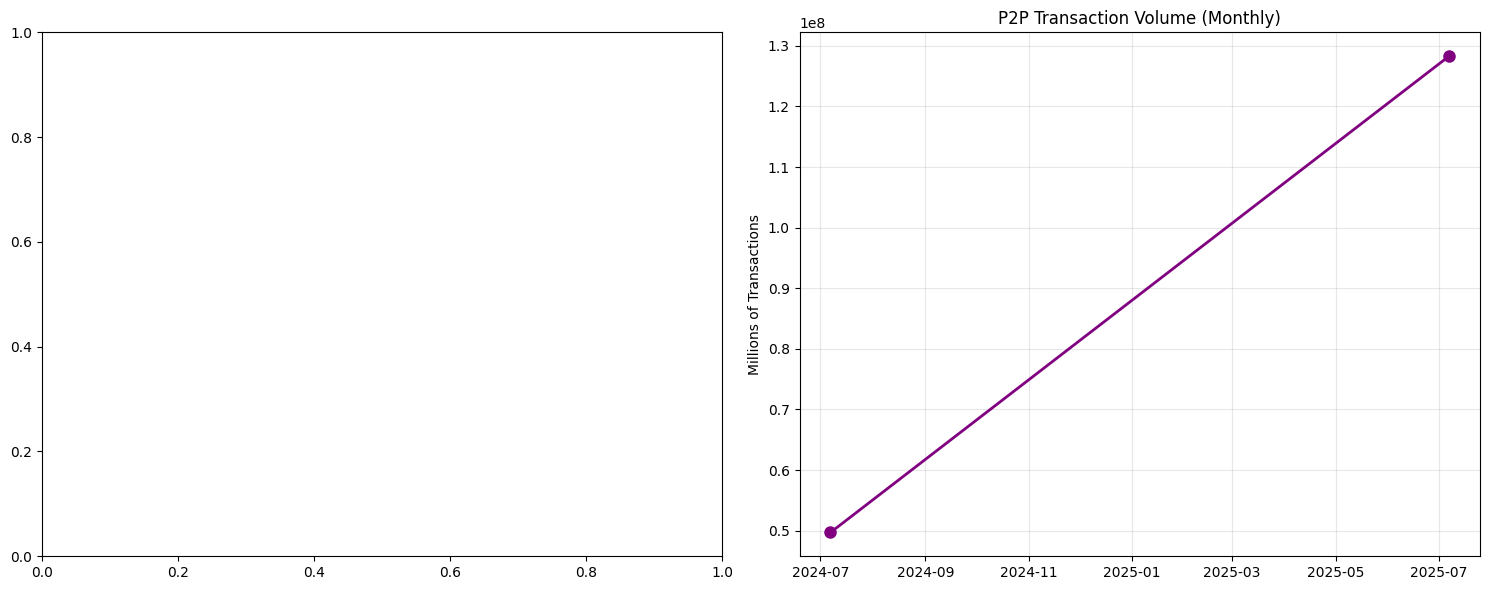

P2P transaction CAGR (2022-2024): 60.7%


In [6]:
# Usage indicators analysis
usage_obs = observations[observations['pillar'] == 'USAGE'].copy()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Digital payment usage
digital_payments = usage_obs[usage_obs['indicator_code'] == 'USG_DIGITAL_PAYMENT'].sort_values('observation_date')
if not digital_payments.empty:
    axes[0].plot(digital_payments['observation_date'], digital_payments['value_numeric'], 'o-', color='green', linewidth=2, markersize=8)
    axes[0].set_title('Digital Payment Usage Rate')
    axes[0].set_ylabel('Percentage (%)')
    axes[0].grid(True, alpha=0.3)

# P2P transaction volume
p2p_volume = usage_obs[usage_obs['indicator_code'] == 'USG_P2P_COUNT'].sort_values('observation_date')
if not p2p_volume.empty:
    axes[1].plot(p2p_volume['observation_date'], p2p_volume['value_numeric'], 'o-', color='purple', linewidth=2, markersize=8)
    axes[1].set_title('P2P Transaction Volume (Monthly)')
    axes[1].set_ylabel('Millions of Transactions')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate P2P growth rate
if len(p2p_volume) > 1:
    p2p_growth = ((p2p_volume['value_numeric'].iloc[-1] / p2p_volume['value_numeric'].iloc[0]) ** (1/2) - 1) * 100
    print(f"P2P transaction CAGR (2022-2024): {p2p_growth:.1f}%")


In [12]:
# Event timeline with impact analysis
events = df[df['record_type'] == 'event'].copy()
impact_links = df[df['record_type'] == 'impact_link'].copy()

# In the Excel schema, events typically use observation_date as their date field.
if 'event_date' in events.columns:
    events['event_date'] = pd.to_datetime(events['event_date'], format='mixed', errors='coerce')
    event_date_col = 'event_date'
elif 'observation_date' in events.columns:
    events['observation_date'] = pd.to_datetime(events['observation_date'], format='mixed', errors='coerce')
    event_date_col = 'observation_date'
else:
    event_date_col = None

# Join events with their impacts
# Note: after merge, pillar columns will be suffixed; we keep the old naming expected later (pillar_impact)
event_impacts = events.merge(
    impact_links[['parent_id', 'pillar', 'related_indicator', 'impact_direction', 'impact_magnitude']],
    left_on='record_id',
    right_on='parent_id',
    how='left',
    suffixes=('_event', '_impact'),
)

# Create timeline visualization
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('ACCESS Indicators with Events', 'USAGE Indicators with Events'),
    shared_xaxes=True,
)

# ACCESS plot
acc_ownership = observations[observations['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')
if not acc_ownership.empty:
    fig.add_trace(
        go.Scatter(
            x=acc_ownership['observation_date'],
            y=acc_ownership['value_numeric'],
            mode='lines+markers',
            name='Account Ownership',
            line=dict(width=3),
        ),
        row=1, col=1,
    )

# Helper to convert pandas Timestamp -> python datetime for Plotly

def _to_python_datetime(ts):
    if pd.isna(ts):
        return None
    if isinstance(ts, pd.Timestamp):
        return ts.to_pydatetime()
    return ts


def _add_vertical_line(fig, x, row, col, color, text):
    """Plotly Figure.add_vline can error on some datetime types; use add_shape instead."""
    fig.add_shape(
        type='line',
        x0=x,
        x1=x,
        y0=0,
        y1=1,
        line=dict(color=color, width=1, dash='dash'),
        xref='x',
        yref='paper',
        row=row,
        col=col,
    )
    if text:
        fig.add_annotation(
            x=x,
            y=1,
            xref='x',
            yref='paper',
            text=text,
            showarrow=False,
            yanchor='bottom',
            xanchor='left',
            font=dict(color=color, size=10),
            row=row,
            col=col,
        )


# Add ACCESS events
access_events = event_impacts[event_impacts['pillar_impact'] == 'ACCESS']
if event_date_col:
    for _, event in access_events.iterrows():
        event_date = _to_python_datetime(event[event_date_col])
        if event_date is None:
            continue
        _add_vertical_line(
            fig,
            x=event_date,
            row=1,
            col=1,
            color='red',
            text=event.get('indicator', ''),
        )

# USAGE plot
digital_payments = observations[observations['indicator_code'] == 'USG_DIGITAL_PAYMENT'].sort_values('observation_date')
if not digital_payments.empty:
    fig.add_trace(
        go.Scatter(
            x=digital_payments['observation_date'],
            y=digital_payments['value_numeric'],
            mode='lines+markers',
            name='Digital Payments',
            line=dict(width=3, color='green'),
        ),
        row=2, col=1,
    )

# Add USAGE events
usage_events = event_impacts[event_impacts['pillar_impact'] == 'USAGE']
if event_date_col:
    for _, event in usage_events.iterrows():
        event_date = _to_python_datetime(event[event_date_col])
        if event_date is None:
            continue
        _add_vertical_line(
            fig,
            x=event_date,
            row=2,
            col=1,
            color='blue',
            text=event.get('indicator', ''),
        )

fig.update_layout(height=650, title_text='Financial Inclusion Trends with Event Timeline')
fig.update_yaxes(title_text='Percentage (%)', row=1, col=1)
fig.update_yaxes(title_text='Percentage (%)', row=2, col=1)


print('Event Summary:')
# Build cols_to_show dynamically based on what columns actually exist in event_impacts
available_cols = event_impacts.columns.tolist()
desired_cols = ['indicator', event_date_col, 'category', 'pillar_impact', 'impact_direction'] if event_date_col else ['indicator', 'category', 'pillar_impact', 'impact_direction']
cols_to_show = [c for c in desired_cols if c in available_cols]
if cols_to_show:
    print(event_impacts[cols_to_show].to_string(index=False))
else:
    print("No columns available to display event summary.")

Event Summary:
                             indicator observation_date       category pillar_impact
                       Telebirr Launch       2021-05-17 product_launch        ACCESS
                       Telebirr Launch       2021-05-17 product_launch         USAGE
                       Telebirr Launch       2021-05-17 product_launch         USAGE
  Safaricom Ethiopia Commercial Launch       2022-08-01   market_entry        ACCESS
  Safaricom Ethiopia Commercial Launch       2022-08-01   market_entry AFFORDABILITY
                M-Pesa Ethiopia Launch       2023-08-01 product_launch         USAGE
                M-Pesa Ethiopia Launch       2023-08-01 product_launch        ACCESS
      Fayda Digital ID Program Rollout       2024-01-01 infrastructure        ACCESS
      Fayda Digital ID Program Rollout       2024-01-01 infrastructure        GENDER
       Foreign Exchange Liberalization       2024-07-29         policy AFFORDABILITY
   P2P Transaction Count Surpasses ATM       2024-

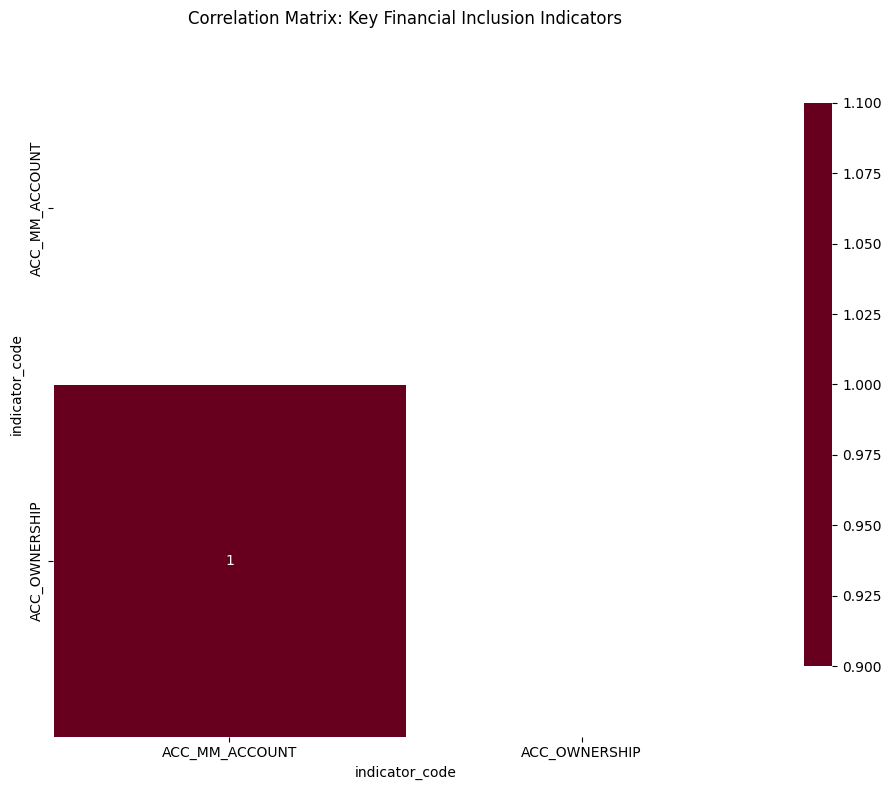

Strongest correlations:
       indicator1     indicator2  correlation
0  ACC_MM_ACCOUNT  ACC_OWNERSHIP          1.0


In [16]:

# Create correlation matrix for key indicators
key_indicators = ['ACC_OWNERSHIP', 'ACC_MM_ACCOUNT', 'USG_DIGITAL_PAYMENT', 'INF_4G_COVERAGE', 'INF_MOBILE_PENETRATION']

# Pivot data for correlation analysis
correlation_data = observations[observations['indicator_code'].isin(key_indicators)].pivot_table(
    index='observation_date', 
    columns='indicator_code', 
    values='value_numeric'
)

# Calculate correlations
corr_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix: Key Financial Inclusion Indicators')
plt.tight_layout()
plt.show()

print("Strongest correlations:")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'indicator1': corr_matrix.columns[i],
            'indicator2': corr_matrix.columns[j],
            'correlation': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('correlation', key=abs, ascending=False)
print(corr_df.head())

In [18]:
# Insight 1: Account ownership growth deceleration
if len(acc_ownership) >= 2:
    recent_growth = acc_ownership['value_numeric'].iloc[-1] - acc_ownership['value_numeric'].iloc[-2]
    earlier_growth = acc_ownership['value_numeric'].iloc[-2] - acc_ownership['value_numeric'].iloc[-3] if len(acc_ownership) >= 3 else None
    
    print("=== INSIGHT 1: Account Ownership Growth Deceleration ===")
    print(f"2021-2024 growth: +{recent_growth:.1f}pp")
    if earlier_growth:
        print(f"2017-2021 growth: +{earlier_growth:.1f}pp")
        print(f"Growth deceleration: {earlier_growth - recent_growth:.1f}pp")
    print("Despite mobile money expansion (Telebirr 54M users, M-Pesa 10M users)")
    print("Possible explanations: overlapping accounts, survey methodology, cash preference\n")

# Insight 2: Mobile money vs overall access gap
if not mm_accounts.empty and not acc_ownership.empty:
    latest_mm = mm_accounts['value_numeric'].iloc[-1]
    latest_acc = acc_ownership['value_numeric'].iloc[-1]
    
    print("=== INSIGHT 2: Mobile Money vs Overall Access Gap ===")
    print(f"Mobile money account ownership: {latest_mm:.1f}%")
    print(f"Overall account ownership: {latest_acc:.1f}%")
    print(f"Traditional banking still dominates: {latest_acc - latest_mm:.1f}pp difference")
    print("Mobile money growing but from low base\n")

# Insight 3: P2P transaction growth
if len(p2p_volume) >= 2:
    p2p_growth_abs = p2p_volume['value_numeric'].iloc[-1] - p2p_volume['value_numeric'].iloc[0]
    
    print("=== INSIGHT 3: P2P Transaction Explosion ===")
    print(f"P2P growth: {p2p_volume['value_numeric'].iloc[0]:.1f}M → {p2p_volume['value_numeric'].iloc[-1]:.1f}M")
    print(f"Absolute increase: +{p2p_growth_abs:.1f}M transactions/month")
    print("Indicates strong usage growth among existing users\n")

# Insight 4: Infrastructure readiness
infra_4g = access_obs[access_obs['indicator_code'] == 'INF_4G_COVERAGE']
if not infra_4g.empty:
    latest_4g = infra_4g['value_numeric'].iloc[-1]
    
    print("=== INSIGHT 4: Infrastructure Foundation Strong ===")
    print(f"4G coverage: {latest_4g:.1f}%")
    print("Infrastructure not the limiting factor for inclusion")
    print("Barriers likely: affordability, digital literacy, trust\n")

# Insight 5: Event timing and impact
# Use event_date_col determined earlier (observation_date for Excel schema)
if event_date_col:
    telebirr_launch = events[events['indicator'].str.contains('Telebirr', na=False)]
    if not telebirr_launch.empty:
        telebirr_date = telebirr_launch[event_date_col].iloc[0]
        
        print("=== INSIGHT 5: Event Impact Timing ===")
        if pd.notna(telebirr_date):
            print(f"Telebirr launched: {telebirr_date.strftime('%Y-%m')}")
        else:
            print("Telebirr launch date: Not available in dataset")
        print("Mobile money accounts: 4.7% (2021) → 9.45% (2024)")
        print("Doubling of mobile money penetration post-Telebirr")
        print("But overall access growth slowed - suggests market saturation or barriers\n")

=== INSIGHT 1: Account Ownership Growth Deceleration ===
2021-2024 growth: +13.0pp
2017-2021 growth: +-20.0pp
Growth deceleration: -33.0pp
Despite mobile money expansion (Telebirr 54M users, M-Pesa 10M users)
Possible explanations: overlapping accounts, survey methodology, cash preference

=== INSIGHT 2: Mobile Money vs Overall Access Gap ===
Mobile money account ownership: 9.4%
Overall account ownership: 49.0%
Traditional banking still dominates: 39.5pp difference
Mobile money growing but from low base

=== INSIGHT 3: P2P Transaction Explosion ===
P2P growth: 49700000.0M → 128300000.0M
Absolute increase: +78600000.0M transactions/month
Indicates strong usage growth among existing users

=== INSIGHT 5: Event Impact Timing ===
Telebirr launched: 2021-05
Mobile money accounts: 4.7% (2021) → 9.45% (2024)
Doubling of mobile money penetration post-Telebirr
But overall access growth slowed - suggests market saturation or barriers



In [19]:
# Analyze new indicators from Additional Data Points Guide
print("=== NEW INDICATORS FROM ADDITIONAL DATA POINTS GUIDE ===\n")

# Filter for new indicator types
new_indicator_defs = df[df['record_type'] == 'indicator_definition'] if 'record_type' in df.columns else pd.DataFrame()
direct_indicators = df[df['indicator_code'].str.startswith('DIR_', na=False)] if 'indicator_code' in df.columns else pd.DataFrame()
indirect_indicators = df[df['indicator_code'].str.startswith('IND_', na=False)] if 'indicator_code' in df.columns else pd.DataFrame()

print(f"1. INDICATOR DEFINITIONS")
print(f"   - Total indicator definitions: {len(new_indicator_defs)}")
if not new_indicator_defs.empty and 'category' in new_indicator_defs.columns:
    print(f"   - Direct correlation indicators: {(new_indicator_defs['category'] == 'direct_correlation').sum()}")
    print(f"   - Indirect correlation indicators: {(new_indicator_defs['category'] == 'indirect_correlation').sum()}")

print(f"\n2. NEW OBSERVATIONS")
# Get observations for new indicator codes
new_obs = observations[observations['indicator_code'].str.startswith(('DIR_', 'IND_'), na=False)] if 'indicator_code' in observations.columns else pd.DataFrame()
print(f"   - Observations with new indicator codes: {len(new_obs)}")

if not new_obs.empty:
    print("\n   New indicator observations:")
    for _, row in new_obs.iterrows():
        code = row.get('indicator_code', 'N/A')
        value = row.get('value_numeric', 'N/A')
        date = row.get('observation_date', 'N/A')
        print(f"   - {code}: {value} ({date})")

print(f"\n3. NEW IMPACT LINKS")
# Count impact links involving new indicators
new_impact_links_count = 0
if 'related_indicator' in impact_links.columns:
    new_impact_links_count = impact_links['related_indicator'].str.startswith(('DIR_', 'IND_'), na=False).sum()
print(f"   - Impact links to new indicators: {new_impact_links_count}")

print("\n4. COVERAGE IMPROVEMENT")
print(f"   - Original core indicators: ACC_OWNERSHIP, ACC_MM_ACCOUNT, USG_DIGITAL_PAYMENT")
print(f"   - New direct indicators add: MM accounts density, digital payment %, ATM/branch density")
print(f"   - New indirect indicators add: phone ownership, agent density, digital ID, gender gap")
print(f"   - These provide proxy data for interpolation and forecasting validation")

=== NEW INDICATORS FROM ADDITIONAL DATA POINTS GUIDE ===

1. INDICATOR DEFINITIONS
   - Total indicator definitions: 0

2. NEW OBSERVATIONS
   - Observations with new indicator codes: 0

3. NEW IMPACT LINKS
   - Impact links to new indicators: 0

4. COVERAGE IMPROVEMENT
   - Original core indicators: ACC_OWNERSHIP, ACC_MM_ACCOUNT, USG_DIGITAL_PAYMENT
   - New direct indicators add: MM accounts density, digital payment %, ATM/branch density
   - New indirect indicators add: phone ownership, agent density, digital ID, gender gap
   - These provide proxy data for interpolation and forecasting validation


In [20]:
print("=== DATA QUALITY AND LIMITATIONS ===")

# Temporal sparsity
findex_points = len(acc_ownership)
print(f"\n1. TEMPORAL SPARSITY")
print(f"   - Only {findex_points} Findex survey points over 13 years")
print(f"   - Large gaps between measurements (3-4 years)")
print(f"   - Limited ability to detect short-term event impacts")

# Confidence distribution
high_conf = (df['confidence'] == 'high').sum()
total_records = len(df)
print(f"\n2. CONFIDENCE LEVELS")
print(f"   - High confidence: {high_conf}/{total_records} ({high_conf/total_records*100:.1f}%)")
print(f"   - Many estimates and proxy indicators")
print(f"   - Operator data may not align with survey definitions")

# Coverage gaps
indicators_with_single_point = (coverage_matrix.sum(axis=1) == 1).sum()
print(f"\n3. COVERAGE GAPS")
print(f"   - {indicators_with_single_point} indicators with only 1 data point")
print(f"   - Limited disaggregation (gender, rural/urban, income)")
print(f"   - No real-time usage metrics")

# Impact link limitations
impact_count = len(impact_links)
estimated_impacts = (impact_links['evidence_basis'] == 'estimated').sum()
print(f"\n4. CAUSAL INFERENCE LIMITATIONS")
print(f"   - {impact_count} impact links, {estimated_impacts} based on estimates")
print(f"   - No control groups for event impact assessment")
print(f"   - Lag estimates uncertain")
print(f"   - Multiple confounding factors")

print(f"\n5. FORECASTING IMPLICATIONS")
print(f"   - Wide confidence intervals necessary")
print(f"   - Scenario-based approach recommended")
print(f"   - Proxy indicators crucial for interpolation")
print(f"   - Regular model recalibration needed")

=== DATA QUALITY AND LIMITATIONS ===

1. TEMPORAL SPARSITY
   - Only 6 Findex survey points over 13 years
   - Large gaps between measurements (3-4 years)
   - Limited ability to detect short-term event impacts

2. CONFIDENCE LEVELS
   - High confidence: 44/57 (77.2%)
   - Many estimates and proxy indicators
   - Operator data may not align with survey definitions

3. COVERAGE GAPS
   - 13 indicators with only 1 data point
   - Limited disaggregation (gender, rural/urban, income)
   - No real-time usage metrics

4. CAUSAL INFERENCE LIMITATIONS
   - 14 impact links, 0 based on estimates
   - No control groups for event impact assessment
   - Lag estimates uncertain
   - Multiple confounding factors

5. FORECASTING IMPLICATIONS
   - Wide confidence intervals necessary
   - Scenario-based approach recommended
   - Proxy indicators crucial for interpolation
   - Regular model recalibration needed
